In [1]:
import os ,sys

from keras.models import Model
from keras.layers import Input,LSTM,GRU,Dense,Embedding,Bidirectional
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set()

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
import keras.backend as K

if len(K.tensorflow_backend._get_available_gpus())>0:
    from keras.layers import CuDNNLSTM  as LSTM
    from keras.layers import CuDNNGRU  as GRU

In [298]:
BATCH_SIZE=32
EPOCHS=5
LATENT_DIM=256
NUM_EXAMPLES=2000
FETC_EXAMPLES=200000
MAX_NUM_WORDS=40000
EMBEDDING_DIM=25


## Data Part

In [ ]:
# Download and unzip glove vector

!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

In [386]:
# Download data
!wget http://www.manythings.org/anki/tur-eng.zip

--2018-12-17 18:20:24--  http://www.manythings.org/anki/tur-eng.zip
Resolving www.manythings.org (www.manythings.org)... 104.24.108.196, 104.24.109.196, 2606:4700:30::6818:6dc4, ...
Connecting to www.manythings.org (www.manythings.org)|104.24.108.196|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10854834 (10M) [application/zip]
Saving to: ‘tur-eng.zip.3’

tur-eng.zip.3         0%[                    ]   2,27K  --.-KB/s    in 0s      

2018-12-17 18:20:25 (199 MB/s) - Connection closed at byte 2328. Retrying.

--2018-12-17 18:20:26--  (try: 2)  http://www.manythings.org/anki/tur-eng.zip
Connecting to www.manythings.org (www.manythings.org)|104.24.108.196|:80... connected.
HTTP request sent, awaiting response... 206 Partial Content
Length: 10854834 (10M), 10852506 (10M) remaining [application/zip]
Saving to: ‘tur-eng.zip.3’

tur-eng.zip.3         0%[                    ]   4,63K  --.-KB/s    in 0,001s  

2018-12-17 18:20:26 (2,28 MB/s) - Connection closed at by

## Preprocess Part

In [321]:
# Load data "tur.txt"

input_texts=[]
target_texts_outputs=[]
target_texts_inputs=[]

t=0

for line in open("tur.txt"):
    t+=1
    
    if t > FETC_EXAMPLES:
        break
        
    if "\t" not in line:
        continue
    
    input_text,translation=line.rstrip().split("\t")
    
    target_text_output=translation +" <eos>"
    target_text_input="<sos> "+translation
    
    input_texts.append(input_text)
    target_texts_outputs.append(target_text_output)
    target_texts_inputs.append(target_text_input)

print("num samples :",len(input_texts))

num samples : 200000


In [322]:
# Shuffle data

indices=np.arange(FETC_EXAMPLES)
np.random.shuffle(indices)

restricted_indices=indices[:NUM_EXAMPLES]
temporal_encoder_inputs=[]
temporal_decoder_inputs=[]
temporal_decoder_outputs=[]

for i in range(NUM_EXAMPLES):
    temporal_encoder_inputs.append(input_texts[restricted_indices[i]])
    temporal_decoder_inputs.append(target_texts_inputs[restricted_indices[i]])
    temporal_decoder_outputs.append(target_texts_outputs[restricted_indices[i]])

print(len(temporal_decoder_outputs))
print(len(temporal_encoder_inputs))

2000
2000


In [323]:
input_texts=temporal_encoder_inputs
target_texts_outputs=temporal_decoder_outputs
target_texts_inputs=temporal_decoder_inputs

In [324]:
max(len(i) for i in input_texts)

28

In [325]:
# Tokenizer encoder part

tokenizer_inputs=Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer_inputs.fit_on_texts(input_texts)
input_sequences=tokenizer_inputs.texts_to_sequences(input_texts)

In [326]:
word2idx_inputs=tokenizer_inputs.word_index

In [327]:
print(input_texts[435])
print(input_sequences[435])

He has a crush on this girl.
[18, 30, 5, 919, 35, 17, 505]


In [328]:
max_len_input=max(len(s) for s in input_sequences)
max_len_input

8

In [329]:
# Tokenizer decoder part

tokenizer_outputs=Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer_outputs.fit_on_texts(target_texts_inputs+target_texts_outputs)
target_sequence_outputs=tokenizer_outputs.texts_to_sequences(target_texts_outputs)
target_sequence_inputs=tokenizer_outputs.texts_to_sequences(target_texts_inputs)

In [330]:
word2idx_outputs=tokenizer_outputs.word_index

In [331]:
num_words_outputs=len(word2idx_outputs)+1 # indexing starts at 1
num_words_outputs

2738

In [332]:
max_len_target=max(len(s) for s in target_sequence_outputs)
max_len_target

8

In [333]:
encoder_inputs = pad_sequences(input_sequences, maxlen=max_len_input)
print(encoder_inputs.shape)
print(encoder_inputs[1])

(2000, 8)
[  0   0   0   0   0   0   1 719]


In [334]:
decoder_inputs=pad_sequences(target_sequence_inputs,maxlen=max_len_target,padding="post")
decoder_targets=pad_sequences(target_sequence_outputs,maxlen=max_len_target,padding="post")

print(decoder_inputs[0])
print(decoder_targets[0])

[  1   5  22 755   0   0   0   0]
[  5  22 755   2   0   0   0   0]


In [335]:
# Load word vectors
word2vec={}

with open("glove.twitter.27B.25d.txt") as f:
    
    for line in f:
        values=line.split()
        word=values[0]
        vec=np.asarray(values[1:],dtype="float32")
        word2vec[word]=vec

    print(len(word2vec))

1193515


In [336]:
# Create embedding matrix

num_words=min(MAX_NUM_WORDS,len(word2idx_inputs)+1)
embedding_matrix=np.zeros((num_words,EMBEDDING_DIM))

print(embedding_matrix.shape)

for word,i in word2idx_inputs.items():
    #print(i)
    if i <MAX_NUM_WORDS:
        embedding_vector=word2vec.get(word)
        if embedding_vector is not None:
            embedding_matrix[i]=embedding_vector

(1683, 25)


In [337]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.083805  , -0.49107999,  0.86660999, ..., -0.62300003,
        -0.034507  , -0.46177   ],
       [-0.26078999,  0.59108001,  0.61622   , ...,  0.076869  ,
         0.22840001,  0.27579999],
       ...,
       [-0.31841999,  0.68676001, -0.51459002, ..., -0.26337001,
        -0.20295   , -0.28849   ],
       [ 0.12692   ,  0.18545   ,  0.20181   , ...,  0.14235   ,
        -0.32359001, -1.10210001],
       [-1.15610003,  0.93615001,  0.36794001, ..., -0.26102   ,
         0.42671999,  0.79075003]])

In [338]:
# Transform decoder target vector to  one hot vector

decoder_targets_one_hot=np.zeros(
    (
        len(input_texts),
        max_len_target,
        num_words_outputs
    ),
    dtype="float32"
)

In [339]:
for i,d in enumerate(decoder_targets):
    for t,word in enumerate(d):
        decoder_targets_one_hot[i,t,word]=1

## Model Part

In [340]:
# embedding layer
embedding_layer=Embedding(
    num_words,
    EMBEDDING_DIM,
    weights=[embedding_matrix],
    input_length=max_len_input,
    #name="encoder_embedding"
    #trainable=True
)

In [341]:
# Encoder Part

encoder_inputs_placeholder=Input(shape=(max_len_input,),name="encoder_inputs")
x=embedding_layer(encoder_inputs_placeholder)

encoder_lstm=LSTM(LATENT_DIM,return_state=True,name="encoder_outputs")
encoder_outputs,h,c=encoder_lstm(x)


In [342]:
encoder_states=[h,c]

In [343]:
# Decoder Part

decoder_inputs_placeholder=Input(shape=(max_len_target,),name="decoder_inputs")
decoder_embedding=Embedding(num_words_outputs,LATENT_DIM,name="decoder_embedding")
decoder_inputs_x=decoder_embedding(decoder_inputs_placeholder)

decoder_lstm=LSTM(LATENT_DIM,return_sequences=True,return_state=True,name="decoder_outputs")
decoder_outputs,_,_=decoder_lstm(decoder_inputs_x,initial_state=encoder_states)

decoder_dense=Dense(num_words_outputs,activation="softmax",name="decoder_softmax")
decoder_outputs=decoder_dense(decoder_outputs)

In [344]:
# Create Model Object

model=Model([encoder_inputs_placeholder,decoder_inputs_placeholder],
            decoder_outputs)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     (None, 8)            0                                            
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     (None, 8)            0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 8, 25)        42075       encoder_inputs[0][0]             
__________________________________________________________________________________________________
decoder_embedding (Embedding)   (None, 8, 256)       700928      decoder_inputs[0][0]             
__________________________________________________________________________________________________
encoder_ou

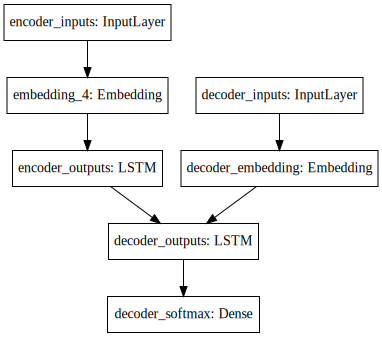

In [345]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog="dot",format="svg"))

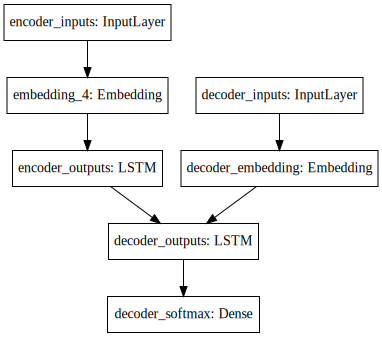

In [346]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [347]:
model.compile(optimizer="rmsprop",loss="categorical_crossentropy",metrics=["accuracy"])

h=model.fit([encoder_inputs,decoder_inputs],decoder_targets_one_hot,
           batch_size=BATCH_SIZE,
           epochs=20,
           validation_split=0.1)
 

Train on 1800 samples, validate on 200 samples
Epoch 1/20
1800/1800 [==============================] - 21s 12ms/step - loss: 3.8335 - acc: 0.4998 - val_loss: 3.3782 - val_acc: 0.5694
Epoch 2/20
1800/1800 [==============================] - 19s 10ms/step - loss: 3.1243 - acc: 0.5823 - val_loss: 3.3470 - val_acc: 0.5713
Epoch 3/20
1800/1800 [==============================] - 19s 10ms/step - loss: 2.9689 - acc: 0.5890 - val_loss: 3.3669 - val_acc: 0.5769
Epoch 4/20
1800/1800 [==============================] - 19s 11ms/step - loss: 2.8352 - acc: 0.5965 - val_loss: 3.3743 - val_acc: 0.5825
Epoch 5/20
1800/1800 [==============================] - 18s 10ms/step - loss: 2.7126 - acc: 0.5997 - val_loss: 3.4314 - val_acc: 0.5900
Epoch 6/20
1800/1800 [==============================] - 19s 11ms/step - loss: 2.6053 - acc: 0.6048 - val_loss: 3.3401 - val_acc: 0.5938
Epoch 7/20
1800/1800 [==============================] - 20s 11ms/step - loss: 2.4958 - acc: 0.6090 - val_loss: 3.4347 - val_acc: 0.5981
E

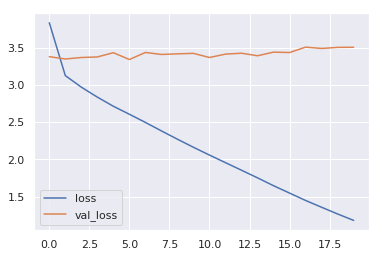

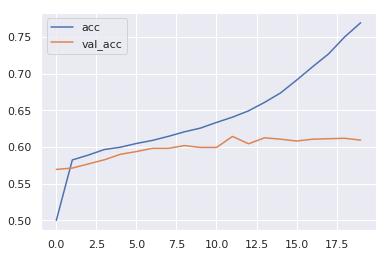

/usr/local/lib/python3.6/dist-packages/keras/engine/network.py:877: UserWarning: Layer decoder_outputs was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'encoder_outputs_4/while/Exit_3:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'encoder_outputs_4/while/Exit_4:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


In [349]:
plt.plot(h.history["loss"],label="loss")
plt.plot(h.history["val_loss"],label="val_loss")
plt.legend()
plt.show()

plt.plot(h.history["acc"],label="acc")
plt.plot(h.history["val_acc"],label="val_acc")
plt.legend()
plt.show()

model.save("deneme.h5")

## Prediction Part

In [350]:
encoder_model=Model(encoder_inputs_placeholder,encoder_states)

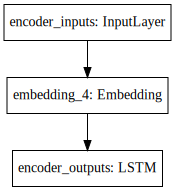

In [351]:
SVG(model_to_dot(encoder_model).create(prog="dot",format="svg"))

In [352]:
decoder_state_input_h=Input(shape=(LATENT_DIM,),name="input_h")
decoder_state_input_c=Input(shape=(LATENT_DIM,),name="input_c")
decoder_states_inputs=[decoder_state_input_h,decoder_state_input_c]

In [353]:
decoder_inputs_single=Input(shape=(1,),name="decoder_input")
decoder_inputs_single_x=decoder_embedding(decoder_inputs_single)

In [354]:
decoder_outputs,h,c=decoder_lstm(decoder_inputs_single_x,
                                 initial_state=decoder_states_inputs)

decoder_states=[h,c]
decoder_outputs=decoder_dense(decoder_outputs)

# The sampling model
# inputs: y(t-1), h(t-1), c(t-1)
# outputs: y(t), h(t), c(t)

decoder_model = Model(
  [decoder_inputs_single] + decoder_states_inputs, 
  [decoder_outputs] + decoder_states
)

decoder_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_input (InputLayer)      (None, 1)            0                                            
__________________________________________________________________________________________________
decoder_embedding (Embedding)   multiple             700928      decoder_input[0][0]              
__________________________________________________________________________________________________
input_h (InputLayer)            (None, 256)          0                                            
__________________________________________________________________________________________________
input_c (InputLayer)            (None, 256)          0                                            
__________________________________________________________________________________________________
decoder_ou

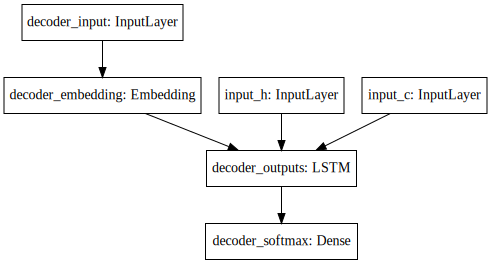

In [355]:
SVG(model_to_dot(decoder_model).create(prog="dot",format="svg"))

In [356]:
# to view the results

idx2word_eng={v:k for k,v in word2idx_inputs.items()}
idx2word_tur={v:k for k,v in word2idx_outputs.items()}

In [357]:
# Choose random a input sentence

i =np.random.choice(len(input_texts))
print(i)
input_sen=encoder_inputs[i:i+1]
input_sen

1227


array([[   0,    0,    0,    0,    2, 1314,   26,  588]], dtype=int32)

In [385]:
# Choose random a input sentence

i =np.random.choice(len(input_texts))
print(i)
input_sen=encoder_inputs[i:i+1]

states_value=encoder_model.predict(input_sen)

target_seq=np.zeros((1,1))
target_seq[0,0]=word2idx_outputs["sos"]
eos=word2idx_outputs["eos"]

output_sentences=[]


for _ in range(max_len_target):
    output_tokens,h,c=decoder_model.predict([target_seq]+states_value)
    
    idx=np.argmax(output_tokens[0,0,:])
    
    if eos==idx:
        print("translation is finished","\n")
        break
    
    word =""
    
    if idx > 0:
        word=idx2word_tur[idx]
        #print(word)
        output_sentences.append(word)
    
   
    target_seq[0,0]=idx
    
    states_value=[h,c]


prediction=""
for i in output_sentences:
    prediction=prediction+i
    prediction=prediction+" "

true=""
for i in range(input_sen.shape[1]):
    if input_sen[0,i]==0:
        continue
    true=true+idx2word_eng[input_sen[0,i]]
    true=true+" "
    
print(prediction,"\n")
print(true)

637
translation is finished 

ne kadar şey musun  

are you doing well 
